# 决策边界绘图

选取一对特征，绘制当前点在其上的决策边界，并结合测试集数据进行分析

# 240403更新

将notebook配置为读取配置文件之后决定特征列表名称以及标签名称，以便于响应变化快速的数据情况

In [1]:
import sklearn
import pandas as pd
import numpy as np
import time
import random
import pickle

In [2]:
import json

# 0. 读取数据

读取数据并转换为机器学习可用的矩阵（numpy格式）

**240403更新，现在机器学习部分会读取`data/settings`文件夹中的`feature.json`和`label.json`文件作为特征以及标签的字段名**

二者与读取进来的文件中相关字段应该是匹配的。

In [3]:
feature_settings_fpath = '../data/settings/feature.json'
label_settings_fpath = '../data/settings/label.json'

In [4]:
with open(feature_settings_fpath, 'r',encoding='utf-8') as file:
    feature_dict = json.load(file)

In [5]:
with open(label_settings_fpath, 'r',encoding='utf-8') as file:
    label_dict = json.load(file)

In [6]:
label_dict

{'index': [0, 1]}

In [7]:
feature_dict

{'q/qm': [0, 200],
 'ploss': [-10000, 10000],
 'fre': [110000, 150000],
 'vpa': [0, 400000],
 'papower': [0, 65000],
 'ch': [0, 8],
 'ce': [-127, 128],
 'rppower': [0, 65000],
 'ss': [0, 255],
 'eff': [0, 1.3]}

In [8]:
# 训练集数据路径
train_fpath = '../data/test_data/train_240409.xlsx'
# 测试集数据路径
test_fpath = '../data/test_data/test_240409.xlsx'

In [9]:
train_df = pd.read_excel(train_fpath)
test_df = pd.read_excel(test_fpath)

In [10]:
train_df

,index,Q/Qm,ploss,fre,Vpa,Papower,ch,CE,RPpower,SS,eff
0,0,112,-1171,143000,11945,2723,8,-8,2500,145,0.918105
1,0,112,-1247,145000,18709,7240,7,0,6350,145,0.877072
2,0,112,-1183,145000,23712,29189,7,1,25677,145,0.879681
3,0,112,-1635,145000,24495,35811,8,0,32095,145,0.896233
4,0,112,-1453,145000,25403,44175,8,2,40329,145,0.912937
...,...,...,...,...,...,...,...,...,...,...,...
403,0,96,-809,145000,26079,45794,7,1,40852,146,0.892082
404,0,96,-756,145000,26151,46104,6,2,41059,146,0.890573
405,0,96,-747,145000,26151,46051,7,2,40997,146,0.890252
406,0,96,-733,145000,26151,46025,7,3,40957,146,0.889886


#### 将所有columns名转换为小写

In [11]:
train_df.columns = [i.lower() for i in train_df.columns]
test_df.columns = [i.lower() for i in test_df.columns]

#### 兼容之前的代码写法

In [12]:
feature_columns = [i for i in list(feature_dict.keys())if i in train_df.columns]

In [13]:
feature_key_lst = feature_columns

In [14]:
feature_range_dict = feature_dict

In [15]:
label_key = list(label_dict.keys())[0]

# 1. 缺失数据补全（todo）

如果存在部分列数据缺失，在这一步骤进行数据的补全以便于减少这部分缺失数据的影响。

### 1.1 补全为0

缺失数据全部用`0`补全

In [16]:
for col in train_df.columns:
    train_df[col] = train_df[col].fillna(0)
    test_df[col] = test_df[col].fillna(0)

# 2. 特征处理

这一步骤针对每列特征进行处理，处理手段有很多种，例如数据分桶，数据扩展，数据统计等等，此处只对数据进行归一化放缩，使得所有特征值范围均在`0,1`之间，以便于机器学习模型学习的稳定性。

后续根据问题的深入程度不同，可以将更多的特征处理手段应用在这一步骤，来增强整体机器学习系统的表现。

## 2.1 数据归一化

根据特征值范围，将现有特征放缩到`(0,1)`之间

In [17]:
for k in feature_key_lst:
    if k not in train_df.columns:
        continue
    # 数据范围上界
    ub = feature_range_dict[k][0]
    # 数据范围下界
    lb = feature_range_dict[k][1]
    
    train_df[k] = train_df[k].apply(lambda x:(x-lb)/(ub-lb))
    test_df[k] = test_df[k].apply(lambda x:(x-lb)/(ub-lb))

## 2.2 输出特征矩阵

输出训练特征矩阵分别为：`train_X`和`test_X`，测试标签为`train_y`和`test_y`。

In [19]:
train_X = train_df[feature_key_lst].to_numpy()

In [20]:
train_X.shape

(408, 10)

In [21]:
test_X = test_df[feature_key_lst].to_numpy()

In [22]:
test_X.shape

(83, 10)

In [23]:
train_y = train_df[label_key].to_numpy()
test_y = test_df[label_key].to_numpy()

# 3. 模型学习

使用`sklearn`工具库自带的机器学习模型对训练数据进行拟合，并在测试数据上测试，评价指标为`precision`,`recall`,`f1_score`,`accuracy`。

不同模型的调参方法不同，可以根据需要进行参数调整。

## 3.0 引入评价指标

In [24]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score

## 3.5 LGB

In [25]:
from lightgbm import LGBMClassifier

In [26]:
# 设置分类阈值 超过该值的分类为1
threshold = 0.5

In [27]:
model = LGBMClassifier(
)

In [28]:
model.fit(train_X,train_y)

[LightGBM] [Info] Number of positive: 240, number of negative: 168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 747
[LightGBM] [Info] Number of data points in the train set: 408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.588235 -> initscore=0.356675
[LightGBM] [Info] Start training from score 0.356675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMClassifier()

In [29]:
pred_y = model.predict(test_X)

In [30]:
pred_test_y = np.array([1 if i>threshold else 0 for i in pred_y])

In [31]:
pred_train = model.predict(train_X)

In [32]:
pred_train_y = np.array([1 if i>threshold else 0 for i in pred_train])

### 训练集分数

In [33]:
p_score = precision_score(train_y, pred_train_y)
r_score = recall_score(train_y, pred_train_y)
f_score = f1_score(train_y, pred_train_y)
acc_score = accuracy_score(train_y, pred_train_y)

### 训练集结果

In [34]:
print(f'Model:{model.__str__()}, Recall:{r_score:.4}, Precision:{p_score:.4} F1:{f_score:.4} Accuracy:{acc_score:.4}')

Model:LGBMClassifier(), Recall:1.0, Precision:1.0 F1:1.0 Accuracy:1.0


In [35]:
pred_train_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

### 测试集分数

In [36]:
p_score = precision_score(test_y, pred_test_y)
r_score = recall_score(test_y, pred_test_y)
f_score = f1_score(test_y, pred_test_y)
acc_score = accuracy_score(test_y, pred_test_y)

### 测试集结果

In [37]:
print(f'Model:{model.__str__()}, Recall:{r_score:.4}, Precision:{p_score:.4} F1:{f_score:.4} Accuracy:{acc_score:.4}')

Model:LGBMClassifier(), Recall:0.9535, Precision:0.9535 F1:0.9535 Accuracy:0.9518


In [38]:
pred_test_y

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# 4. 绘制决策边界图

绘制决策边界，图像需要是2D图像并且需要打点，需要几种不同的绘图方案，搭配不同的学习模型来决定。

模型部分：`线性回归`、`决策树`、`SVM`、`GBDT`

绘图策略部分：

1. 每次用模型只学习两组特征，结合两组特征和训练集上的预测情况进行绘图，画出边界，之后测试集数据选取对应两组，预测打点

2. 使用全部特征进行训练，绘图时只选择两组特征进行绘图，将训练集数据打点之后用`contourf`函数来绘制边界以及测试集数据打点

3. 使用全部特征训练，使用`PCA`降维，将特征空间压缩到2D，绘图，之后测试集使用同样的`PCA`对象进行降维，打点

In [39]:
import matplotlib.pyplot as plt

In [40]:
%matplotlib inline

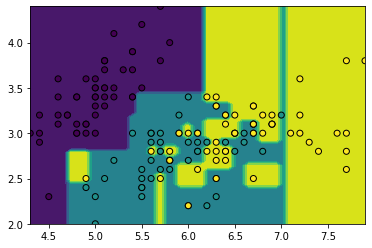

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier
iris = load_iris()
feature_1, feature_2 = np.meshgrid(
    np.linspace(iris.data[:, 0].min(), iris.data[:, 0].max()),
    np.linspace(iris.data[:, 1].min(), iris.data[:, 1].max())
)
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
tree = DecisionTreeClassifier().fit(iris.data[:, :2], iris.target)
y_pred = np.reshape(tree.predict(grid), feature_1.shape)
display = DecisionBoundaryDisplay(
    xx0=feature_1, xx1=feature_2, response=y_pred
)
display.plot()
display.ax_.scatter(
    iris.data[:, 0], iris.data[:, 1], c=iris.target, edgecolor="black"
)
plt.show()